# QC of metacells built with SuperCell
SuperCell ran in R

## Imports

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

import SEACells
import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

In [3]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.append('../../Py/') # make a MC_metrics.py script to stote metric functions
import mc_QC

## Parameter
Requested graining level

In [4]:
I = 2
gamma = [10, 20, 30, 50, 75, 100][I] # graining level

proj_name = ["cell_lines", "3k_pbmc"][1]

annotation_label = {'cell_lines':'cell_line',
                   '3k_pbmc':'louvain'}[proj_name]

MC_tool = "SuperCell"

## Load data

In [5]:
# Load data pre-filtered data

data_folder = os.path.join("../../data/", proj_name)
ad = sc.read(os.path.join(data_folder, "anndata_filtered.h5ad"))



In [6]:
membership = pd.read_csv(os.path.join(data_folder, "output", f"supercell_gamma_{gamma}_membership.csv"), 
                        index_col=0, header=0, names=["membership"])

membership


,membership
AAACATACAACCAC-1,46
AAACATTGAGCTAC-1,6
AAACATTGATCAGC-1,10
AAACCGTGCTTCCG-1,7
AAACCGTGTATGCG-1,44
...,...
TTTCGAACTCTCAT-1,42
TTTCTACTGAGGCA-1,38
TTTCTACTTCCTCG-1,55
TTTGCATGAGAGGC-1,23


## Data processing 
In contrast to [Metacell-2](), SEACells build metacells based on processed data and takes as an input dimensionally reduced data (i.e., PCA for scRNA-seq data). Thus, we first compute PCA for our data usign the same set of genes used in the main [tutorial]()

In [7]:
# Save count as a separate layer
ad.layers['counts'] = ad.X

# Copy the counts to ".raw" attribute of the anndata since it is necessary for downstream analysis
# This step should be performed after filtering 
raw_ad = sc.AnnData(ad.layers['counts'])
raw_ad.obs_names, raw_ad.var_names = ad.obs_names, ad.var_names
ad.raw = raw_ad

In [8]:
# Normalize cells, log transform and compute highly variable genes
sc.pp.normalize_per_cell(ad)
sc.pp.log1p(ad)
sc.pp.highly_variable_genes(ad, n_top_genes=1000)


In [9]:
# Compute principal components - 
# Here we use 10 components to be consistent with out main tutorial, but fill free to explore other number of principal components to use 

n_comp    = 10
sc.tl.pca(ad, n_comps=n_comp, use_highly_variable=True)

# Compute UMAP for visualization 
sc.pp.neighbors(ad, n_neighbors=10, n_pcs=n_comp)
sc.tl.umap(ad)

## Loading metacells from SuperCell membership

In [10]:
ad.obs = ad.obs.join(membership)

ad.obs['SEACell'] = ad.obs['membership']
ad.obs

,n_genes,percent_mito,n_counts,louvain,membership,SEACell
index,,,,,,
AAACATACAACCAC-1,781,0.030178,2421.0,CD4 T cells,46,46
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,6,6
AAACATTGATCAGC-1,1131,0.008897,3149.0,CD4 T cells,10,10
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,7,7
AAACCGTGTATGCG-1,522,0.012245,981.0,NK cells,44,44
...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3461.0,CD14+ Monocytes,42,42
TTTCTACTGAGGCA-1,1227,0.009294,3447.0,B cells,38,38
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells,55,55


In [11]:
SEACell_ad = SEACells.core.summarize_by_SEACell(ad, SEACells_label='membership', summarize_layer='raw')


100%|██████████████████████████████████████████| 88/88 [00:00<00:00, 414.55it/s]


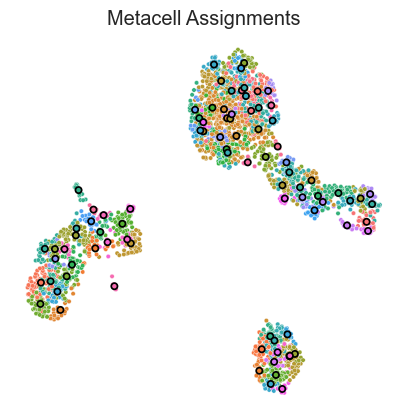

In [12]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=True)

In [13]:
## Save single-cell metadata (i.e., `ad.obs` dataframe) in the seacell adata object
SEACell_ad.uns = ad.uns.copy()
SEACell_ad.uns['sc.obs'] = ad.obs.copy()

SEACell_ad.var['feature_gene'] = ad.var['highly_variable'].astype(int)
SEACell_ad.obs['membership'] =  [int(i) for i in SEACell_ad.obs.index]
SEACell_ad.obs['gamma'] = gamma
SEACell_ad.obs['gamma_obtained'] = round(ad.shape[0]/SEACell_ad.shape[0])
SEACell_ad.obs['MC_tool'] = MC_tool


SEACell_ad.obs

,membership,gamma,gamma_obtained,MC_tool
46,46,30,30,SuperCell
6,6,30,30,SuperCell
10,10,30,30,SuperCell
7,7,30,30,SuperCell
44,44,30,30,SuperCell
...,...,...,...,...
88,88,30,30,SuperCell
63,63,30,30,SuperCell
86,86,30,30,SuperCell
62,62,30,30,SuperCell


In [14]:
SEACell_ad.uns['sc.obs']

,n_genes,percent_mito,n_counts,louvain,membership,SEACell
index,,,,,,
AAACATACAACCAC-1,781,0.030178,2421.0,CD4 T cells,46,46
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B cells,6,6
AAACATTGATCAGC-1,1131,0.008897,3149.0,CD4 T cells,10,10
AAACCGTGCTTCCG-1,960,0.017431,2639.0,CD14+ Monocytes,7,7
AAACCGTGTATGCG-1,522,0.012245,981.0,NK cells,44,44
...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3461.0,CD14+ Monocytes,42,42
TTTCTACTGAGGCA-1,1227,0.009294,3447.0,B cells,38,38
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B cells,55,55


### Metacell quality metrics 

In [15]:
mc_size_dist = ad.obs.membership.value_counts()
mc_size = pd.DataFrame(mc_size_dist).rename(columns={'membership':'size'})
mc_size['membership'] = mc_size.index

In [16]:
SEACell_ad.obs = pd.merge(SEACell_ad.obs, mc_size, on=['membership'])

SEACell_ad.obs

/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


,membership,gamma,gamma_obtained,MC_tool,size
0,46,30,30,SuperCell,41
1,6,30,30,SuperCell,44
2,10,30,30,SuperCell,166
3,7,30,30,SuperCell,29
4,44,30,30,SuperCell,23
...,...,...,...,...,...
83,88,30,30,SuperCell,5
84,63,30,30,SuperCell,13
85,86,30,30,SuperCell,5
86,62,30,30,SuperCell,8


In [17]:
import importlib
importlib.reload(mc_QC)

MC_purity = mc_QC.purity(ad, annotation_label, MC_label = 'membership')
print(MC_purity)
MC_purity.index = SEACell_ad.obs.index
print(MC_purity)


SEACell_ad.obs = SEACell_ad.obs.join(MC_purity) #pd.merge(metacells.obs, MC_purity, left_index=True, right_index=True)


                    louvain  louvain_purity
membership                                 
1               CD4 T cells        0.945946
2               CD4 T cells        1.000000
3                  NK cells        0.968750
4               CD4 T cells        0.982759
5           CD14+ Monocytes        0.986667
...                     ...             ...
84           Megakaryocytes        1.000000
85              CD4 T cells        1.000000
86              CD4 T cells        0.600000
87          CD14+ Monocytes        0.600000
88              CD4 T cells        1.000000

[88 rows x 2 columns]
            louvain  louvain_purity
0       CD4 T cells        0.945946
1       CD4 T cells        1.000000
2          NK cells        0.968750
3       CD4 T cells        0.982759
4   CD14+ Monocytes        0.986667
..              ...             ...
83   Megakaryocytes        1.000000
84      CD4 T cells        1.000000
85      CD4 T cells        0.600000
86  CD14+ Monocytes        0.600000
87      C

/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [18]:
SEACell_ad.obs = SEACell_ad.obs.iloc[:,:7]
SEACell_ad.obs
#n_comp

,membership,gamma,gamma_obtained,MC_tool,size,louvain,louvain_purity
0,46,30,30,SuperCell,41,CD4 T cells,0.945946
1,6,30,30,SuperCell,44,CD4 T cells,1.000000
2,10,30,30,SuperCell,166,NK cells,0.968750
3,7,30,30,SuperCell,29,CD4 T cells,0.982759
4,44,30,30,SuperCell,23,CD14+ Monocytes,0.986667
...,...,...,...,...,...,...,...
83,88,30,30,SuperCell,5,Megakaryocytes,1.000000
84,63,30,30,SuperCell,13,CD4 T cells,1.000000
85,86,30,30,SuperCell,5,CD4 T cells,0.600000
86,62,30,30,SuperCell,8,CD14+ Monocytes,0.600000


In [19]:
SEACell_ad.obs['size'].value_counts()


14     9
21     5
15     4
22     4
27     3
5      3
29     3
20     3
45     2
24     2
41     2
19     2
32     2
13     2
8      2
12     2
6      2
11     2
9      2
57     2
53     2
23     2
50     2
37     2
31     1
7      1
166    1
18     1
28     1
34     1
26     1
42     1
38     1
62     1
58     1
73     1
51     1
75     1
67     1
49     1
86     1
16     1
68     1
44     1
43     1
54     1
Name: size, dtype: int64

In [20]:
import importlib
importlib.reload(mc_QC)
MC_label = 'membership'

compactness_PCA = mc_QC.compactness(ad, 'X_pca', MC_label = MC_label, DO_DC = False, name = 'Compactness_PCA', n_comp=n_comp)['Compactness_PCA']
compactness_DC  = mc_QC.compactness(ad, 'X_pca', MC_label = MC_label, DO_DC = True, name = 'Compactness_DC', n_comp=n_comp)['Compactness_DC']

SEACell_ad.obs = SEACell_ad.obs.join(compactness_PCA, on = MC_label)
SEACell_ad.obs = SEACell_ad.obs.join(compactness_DC, on = MC_label)

separation_PCA = mc_QC.separation(ad, 'X_pca', MC_label = MC_label, DO_DC = False, name = 'Separation_PCA', n_comp=n_comp)['Separation_PCA']
separation_DC  = mc_QC.separation(ad, 'X_pca', MC_label = MC_label, DO_DC = True, name = 'Separation_DC', n_comp=n_comp)['Separation_DC']

SEACell_ad.obs = SEACell_ad.obs.join(separation_PCA, on = MC_label)
SEACell_ad.obs = SEACell_ad.obs.join(separation_DC, on = MC_label)

SEACell_ad.obs


Determing nearest neighbor graph...


/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


Determing nearest neighbor graph...


/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


,membership,gamma,gamma_obtained,MC_tool,size,louvain,louvain_purity,Compactness_PCA,Compactness_DC,Separation_PCA,Separation_DC
0,46,30,30,SuperCell,41,CD4 T cells,0.945946,0.187090,0.021678,0.956998,0.098032
1,6,30,30,SuperCell,44,CD4 T cells,1.000000,0.142154,0.449726,0.916583,0.116313
2,10,30,30,SuperCell,166,NK cells,0.968750,0.127220,0.010312,0.715143,0.018188
3,7,30,30,SuperCell,29,CD4 T cells,0.982759,0.178689,0.258951,1.196595,0.680645
4,44,30,30,SuperCell,23,CD14+ Monocytes,0.986667,0.289994,0.008426,1.410216,0.133064
...,...,...,...,...,...,...,...,...,...,...,...
83,88,30,30,SuperCell,5,Megakaryocytes,1.000000,0.084525,0.125876,1.699140,0.076161
84,63,30,30,SuperCell,13,CD4 T cells,1.000000,0.122656,0.019571,1.560223,0.098032
85,86,30,30,SuperCell,5,CD4 T cells,0.600000,0.132432,0.136562,2.148690,0.717232
86,62,30,30,SuperCell,8,CD14+ Monocytes,0.600000,0.060078,0.000656,1.143069,0.033533


In [21]:
# compute extra PC to evaluate performance of compactness and separation outside the n_comp used for MC construction
sc.tl.pca(ad, n_comps=50, use_highly_variable=True)
ad.obsm['X_pca'].shape

(2638, 50)

### Compute *compactness* for a range of latent space components 

In [22]:
QC_compactness = pd.DataFrame()

# Compactness

for n_comp_i in range(2, 31, 2):
    print(n_comp_i)
    
    compactness_PCA_i = mc_QC.compactness(ad, 'X_pca', n_comp = n_comp_i, DO_DC = False, MC_label = MC_label)
    compactness_DC_i  = mc_QC.compactness(ad, 'X_pca', n_comp = n_comp_i, DO_DC = True, MC_label = MC_label)
    
    QC_compactness = pd.concat([QC_compactness, compactness_PCA_i, compactness_DC_i], ignore_index=True)
QC_compactness


2
Determing nearest neighbor graph...
4
Determing nearest neighbor graph...
6
Determing nearest neighbor graph...
8
Determing nearest neighbor graph...
10
Determing nearest neighbor graph...
12
Determing nearest neighbor graph...
14
Determing nearest neighbor graph...
16
Determing nearest neighbor graph...
18
Determing nearest neighbor graph...
20
Determing nearest neighbor graph...
22
Determing nearest neighbor graph...
24
Determing nearest neighbor graph...
26
Determing nearest neighbor graph...
28
Determing nearest neighbor graph...
30
Determing nearest neighbor graph...


,compactness,low_dim_embedding,n_comp,membership
0,0.095831,X_pca,2,1
1,0.114982,X_pca,2,2
2,0.282246,X_pca,2,3
3,0.127724,X_pca,2,4
4,0.193376,X_pca,2,5
...,...,...,...,...
2635,0.012277,DC,30,84
2636,0.007550,DC,30,85
2637,0.017886,DC,30,86
2638,0.006957,DC,30,87


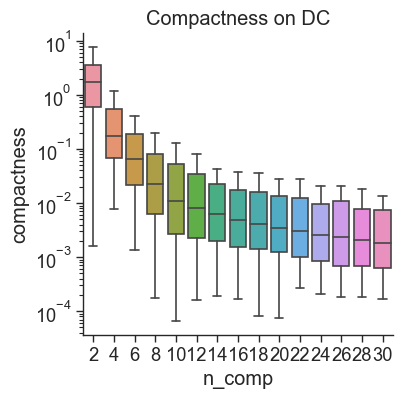

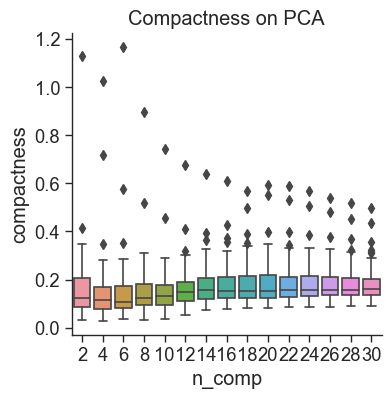

In [23]:

plt.figure(figsize=(4,4))
sns.boxplot(data=QC_compactness[QC_compactness.low_dim_embedding == 'DC'], y='compactness', x = 'n_comp', showfliers = False)
plt.yscale('log')
plt.title('Compactness on DC')
sns.despine()
plt.show()
plt.close()

plt.figure(figsize=(4,4))
sns.boxplot(data=QC_compactness[QC_compactness.low_dim_embedding == 'X_pca'], y='compactness', x = 'n_comp')
#plt.yscale('log')
plt.title('Compactness on PCA')
sns.despine()
plt.show()
plt.close()



### Compute *separation* for a range of latent space components 

In [24]:
importlib.reload(mc_QC)
QC_separation = pd.DataFrame()

#Separation

for n_comp_i in range(2, 31, 2):
    print(n_comp_i)
    sep_PCA_i = mc_QC.separation(ad, 'X_pca', n_comp = n_comp_i, DO_DC = False, MC_label = MC_label)
    sep_DC_i = mc_QC.separation(ad, 'X_pca', n_comp = n_comp_i, DO_DC = True, MC_label = MC_label)
    
    
    QC_separation = pd.concat([QC_separation, sep_PCA_i, sep_DC_i], ignore_index=True)
QC_separation

2
Determing nearest neighbor graph...
4
Determing nearest neighbor graph...
6
Determing nearest neighbor graph...
8
Determing nearest neighbor graph...
10
Determing nearest neighbor graph...
12
Determing nearest neighbor graph...
14
Determing nearest neighbor graph...
16
Determing nearest neighbor graph...
18
Determing nearest neighbor graph...
20
Determing nearest neighbor graph...
22
Determing nearest neighbor graph...
24
Determing nearest neighbor graph...
26
Determing nearest neighbor graph...
28
Determing nearest neighbor graph...
30
Determing nearest neighbor graph...


,separation,low_dim_embedding,n_comp,membership
0,0.058379,X_pca,2,1
1,0.060569,X_pca,2,2
2,0.124251,X_pca,2,3
3,0.040057,X_pca,2,4
4,0.136993,X_pca,2,5
...,...,...,...,...
2635,4.294468,DC,30,84
2636,0.222279,DC,30,85
2637,0.653372,DC,30,86
2638,0.247274,DC,30,87


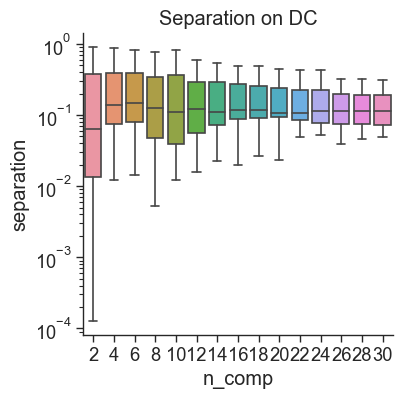

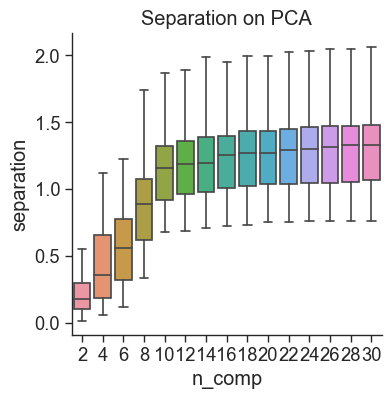

In [25]:
plt.figure(figsize=(4,4))
sns.boxplot(data=QC_separation[QC_separation.low_dim_embedding == 'DC'], y='separation', x = 'n_comp', showfliers = False)
plt.yscale('log')
plt.title('Separation on DC')
sns.despine()
plt.show()
plt.close()

plt.figure(figsize=(4,4))
sns.boxplot(data=QC_separation[QC_separation.low_dim_embedding == 'X_pca'], y='separation', x = 'n_comp', showfliers = False)
#plt.yscale('log')
plt.title('Separation on PCA')
sns.despine()
plt.show()
plt.close()

In [26]:
QC = QC_compactness.merge(QC_separation, on=['low_dim_embedding', 'n_comp', 'membership'])

QC = SEACell_ad.obs.iloc[:,:7].merge(QC, on = 'membership')

QC

,membership,gamma,gamma_obtained,MC_tool,size,louvain,louvain_purity,compactness,low_dim_embedding,n_comp,separation
0,46,30,30,SuperCell,41,CD4 T cells,0.945946,0.186340,X_pca,2,0.133860
1,46,30,30,SuperCell,41,CD4 T cells,0.945946,3.586526,DC,2,0.172845
2,46,30,30,SuperCell,41,CD4 T cells,0.945946,0.172504,X_pca,4,0.155257
3,46,30,30,SuperCell,41,CD4 T cells,0.945946,1.167215,DC,4,0.133057
4,46,30,30,SuperCell,41,CD4 T cells,0.945946,0.172072,X_pca,6,0.321528
...,...,...,...,...,...,...,...,...,...,...,...
2635,85,30,30,SuperCell,6,CD4 T cells,1.000000,0.014371,DC,26,0.259387
2636,85,30,30,SuperCell,6,CD4 T cells,1.000000,0.169715,X_pca,28,1.788415
2637,85,30,30,SuperCell,6,CD4 T cells,1.000000,0.009603,DC,28,0.226151
2638,85,30,30,SuperCell,6,CD4 T cells,1.000000,0.161353,X_pca,30,1.807546


Text(0.3, 0, 'r = 0.2066')

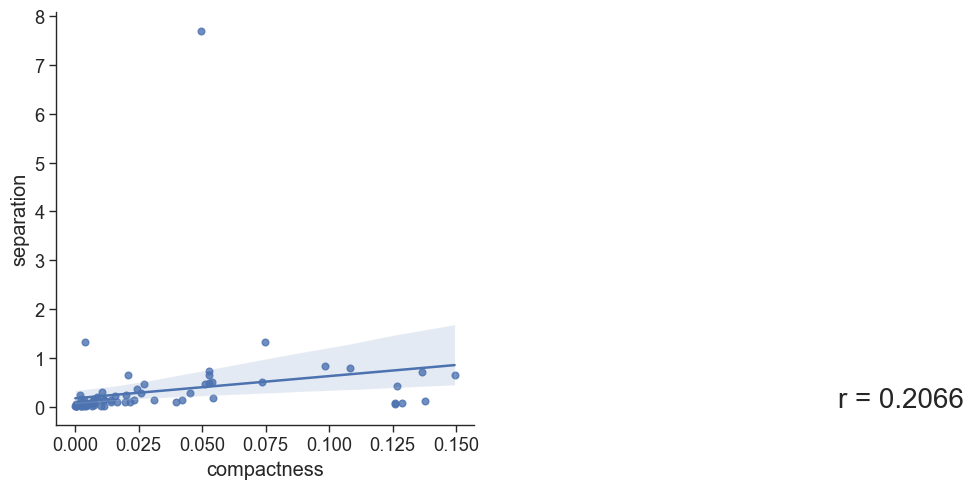

In [27]:
import scipy
df = QC[(QC['low_dim_embedding'] == 'DC') & (QC['n_comp'] == 10)]
#df['size'] = mc_size.cell_line
df = df[(df['separation']<100) & (df['compactness']<.2)]
r = df.compactness.corr(df.separation)

#sns.scatterplot(x="compactness", y="separation", data=df)
sns.lmplot(x="compactness", y="separation", data=df)

#add correlation coefficient to plot
plt.text(.3,0, 'r = ' + str(round(r, 4)), fontsize=20)


In [28]:
importlib.reload(mc_QC)
ad.obs['membership_str'] = [str(i-1) for i in ad.obs.membership]
mc_INV = mc_QC.mc_inner_normalized_var(ad, MC_label='membership_str')
mc_INV.index = [int(i) for i in mc_INV.index]

/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/pandas/core/arraylike.py:490: RuntimeWarning: divide by zero encountered in reciprocal
  return getattr(ufunc, method)(*new_inputs, **kwargs)


In [29]:
SEACell_ad.obs


,membership,gamma,gamma_obtained,MC_tool,size,louvain,louvain_purity,Compactness_PCA,Compactness_DC,Separation_PCA,Separation_DC
0,46,30,30,SuperCell,41,CD4 T cells,0.945946,0.187090,0.021678,0.956998,0.098032
1,6,30,30,SuperCell,44,CD4 T cells,1.000000,0.142154,0.449726,0.916583,0.116313
2,10,30,30,SuperCell,166,NK cells,0.968750,0.127220,0.010312,0.715143,0.018188
3,7,30,30,SuperCell,29,CD4 T cells,0.982759,0.178689,0.258951,1.196595,0.680645
4,44,30,30,SuperCell,23,CD14+ Monocytes,0.986667,0.289994,0.008426,1.410216,0.133064
...,...,...,...,...,...,...,...,...,...,...,...
83,88,30,30,SuperCell,5,Megakaryocytes,1.000000,0.084525,0.125876,1.699140,0.076161
84,63,30,30,SuperCell,13,CD4 T cells,1.000000,0.122656,0.019571,1.560223,0.098032
85,86,30,30,SuperCell,5,CD4 T cells,0.600000,0.132432,0.136562,2.148690,0.717232
86,62,30,30,SuperCell,8,CD14+ Monocytes,0.600000,0.060078,0.000656,1.143069,0.033533


In [30]:
SEACell_ad.obs = SEACell_ad.obs.iloc[:,:11]
SEACell_ad.obs


/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


,membership,gamma,gamma_obtained,MC_tool,size,louvain,louvain_purity,Compactness_PCA,Compactness_DC,Separation_PCA,Separation_DC
0,46,30,30,SuperCell,41,CD4 T cells,0.945946,0.187090,0.021678,0.956998,0.098032
1,6,30,30,SuperCell,44,CD4 T cells,1.000000,0.142154,0.449726,0.916583,0.116313
2,10,30,30,SuperCell,166,NK cells,0.968750,0.127220,0.010312,0.715143,0.018188
3,7,30,30,SuperCell,29,CD4 T cells,0.982759,0.178689,0.258951,1.196595,0.680645
4,44,30,30,SuperCell,23,CD14+ Monocytes,0.986667,0.289994,0.008426,1.410216,0.133064
...,...,...,...,...,...,...,...,...,...,...,...
83,88,30,30,SuperCell,5,Megakaryocytes,1.000000,0.084525,0.125876,1.699140,0.076161
84,63,30,30,SuperCell,13,CD4 T cells,1.000000,0.122656,0.019571,1.560223,0.098032
85,86,30,30,SuperCell,5,CD4 T cells,0.600000,0.132432,0.136562,2.148690,0.717232
86,62,30,30,SuperCell,8,CD14+ Monocytes,0.600000,0.060078,0.000656,1.143069,0.033533


In [31]:
mc_INV_val = mc_INV.quantile([0.05, 0.5, 0.95], axis=1, numeric_only=True)
mc_INV_val = pd.DataFrame(mc_INV_val.transpose()).set_axis(['INV_5', 'INV_50','INV_95'], axis=1, inplace=False)
#mc_INV_val = pd.DataFrame.from_dict(mc_INV_val, orient='index', columns=['INV_95'])
SEACell_ad.obs = SEACell_ad.obs.join(mc_INV_val)

/Users/mariiabilous/opt/anaconda3/envs/metacell_tutorial_/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [32]:
SEACell_ad.obs

,membership,gamma,gamma_obtained,MC_tool,size,louvain,louvain_purity,Compactness_PCA,Compactness_DC,Separation_PCA,Separation_DC,INV_5,INV_50,INV_95
0,46,30,30,SuperCell,41,CD4 T cells,0.945946,0.187090,0.021678,0.956998,0.098032,0.000109,0.000994,0.068632
1,6,30,30,SuperCell,44,CD4 T cells,1.000000,0.142154,0.449726,0.916583,0.116313,0.000227,0.002183,0.112033
2,10,30,30,SuperCell,166,NK cells,0.968750,0.127220,0.010312,0.715143,0.018188,0.000242,0.001917,0.125933
3,7,30,30,SuperCell,29,CD4 T cells,0.982759,0.178689,0.258951,1.196595,0.680645,0.000050,0.000616,0.045843
4,44,30,30,SuperCell,23,CD14+ Monocytes,0.986667,0.289994,0.008426,1.410216,0.133064,0.000025,0.000456,0.078832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,88,30,30,SuperCell,5,Megakaryocytes,1.000000,0.084525,0.125876,1.699140,0.076161,0.000075,0.002687,0.476316
84,63,30,30,SuperCell,13,CD4 T cells,1.000000,0.122656,0.019571,1.560223,0.098032,0.007392,0.029593,0.453687
85,86,30,30,SuperCell,5,CD4 T cells,0.600000,0.132432,0.136562,2.148690,0.717232,0.000919,0.005101,0.145304
86,62,30,30,SuperCell,8,CD14+ Monocytes,0.600000,0.060078,0.000656,1.143069,0.033533,0.004137,0.012010,0.262895


In [33]:
SEACell_ad.uns['QC_separation_compactness_PC_range'] = QC

## Saving data for the downstream analysis

In [34]:
meth_name = 'supercell'
SEACell_ad.write(os.path.join(data_folder, 'output', f'{meth_name}_gamma_{gamma}.h5ad'))
SEACell_ad.obs.to_csv(os.path.join(data_folder, 'output', f'{meth_name}_gamma_{gamma}_metacell_obs.csv'))
ad.obs.to_csv(os.path.join(data_folder, 'output', f'{meth_name}_gamma_{gamma}_singlecell_obs.csv'))
QC.to_csv(os.path.join(data_folder, 'output', f'{meth_name}_gamma_{gamma}_QC.csv'))


In [35]:
gamma

30